## time-to-event modelling and survival prediction

**Set-up instructions:** On binder, this should run out-of-the-box.

To run locally instead, ensure that `skpro` with basic dependency requirements is installed in your python environment.

---

`skpro` provides a unified interface to time-to-event prediction models, also known as survival prediction models.

**Time-to-event prediction** is a form of probabilistic regression where **labels can be "censored"**, i.e., of the form "time is t or later" instead of exact observations.

**Section 1** provides an overview of the basic **time-to-event prediction workflows** supported by `skpro`.

**Section 2** showcases **performance metrics and benchmarking** for time-to-event prediction with censored data.

**Section 3** discusses **advanced composition patterns**, including various ways to leverage `sklearn` regressors for time-to-event prediction with censored data.

**Section 4** gives an introduction to how to write **custom estimators** compliant with the `skpro` interface.

In [50]:
# hide warnings
import warnings

warnings.filterwarnings("ignore")

## 1. Basic survival prediction interface <a class="anchor" id="chapter1"></a>

In this section:

* explanation of censored time-to-event data
* `skpro` time-to-event/survival prediction interface
* metrics, evaluation

### 1.1 data representation, censoring

Survival prediction or time-to-event prediction can be seen a generalization of probabilistic supervised learning.


Each sample consists of:

* a feature vector, row of a data frame
* a label, which can be an exact time of occurrence, or a statement about "time was t or later"

In [51]:
# simulated toy dataset, lung cancer survival times
import numpy as np

# demographics - age and smoker yes/no
age = np.random.uniform(low=20, high=100, size=50)
smoker = np.random.binomial(1, 0.3, size=50)

# actual survival time
scale = 200 / (0.5 * age + 30 * smoker)
survival = scale * np.random.weibull(1, size=50)

# patients are observed only for 5 years
# if they surviva 5 years, we know they survived 5 years, but not exact time of death
censored = survival > 5
observation = np.minimum(survival, 5)

`skpro` represents this information in an `sklearn`-like interface:

In [52]:
import pandas as pd

# features
X = pd.DataFrame({"age": age, "smoker": smoker})

# time of survival or censoring
y = pd.DataFrame({"time": observation})

# indicator whether event was observed or censored
# censored = 1/True, observed = 0/False
# variable names should be the same as for y
C = pd.DataFrame({"time": censored})

In [53]:
X.head()

,age,smoker
0,64.492963,0
1,37.484283,0
2,98.567493,0
3,32.863923,1
4,83.944665,0


In [54]:
y.head()

,time
0,1.121047
1,5.000000
2,4.435677
3,5.000000
4,4.049751


In [55]:
C.head()

,time
0,False
1,True
2,False
3,True
4,False


### 1.2 basic survival prediction workflow

survival prediction is the task:

* given censored time-to-event labels and features, `X`, `y`, `C`
* learn a model that can predict `y` if it were uncensored, i.e., the true event time
* the prediction should take the form of a survival function or probability distribution

`skpro` survival predictors extend the interface of probabilistic regressors:

* `fit(X, y, C=None)`, with `X`, `y`, `C` as above; if `C=None`, all observations are uncensored
* `predict(X_test)` for mean survival time predictions
* `predict_proba(X_test)` for distributional predictions

Other prediction methods - `predict_interval`, `predict_quantiles`, `predict_var` - also generalize the same way.

Because `C` is optional, and means "uncensored" if not passed, all survival prediction models can be used as supervised probabilistic regressors.

Using probabilistic regressors as survival models is similarly possible, to be revisited later.

Basic deployment workflow:

In [56]:
from sklearn.model_selection import train_test_split

from skpro.survival.coxph import CoxPH

# step 1: data specification
# X, y, C, as above
X_train, X_new, y_train, _, C_train, _ = train_test_split(X, y, C)

# step 2: specifying the regressor
# example - Cox proportional hazards model from statsmodels
surv_model_cox = CoxPH()

# step 3: fitting the model to training data
surv_model_cox.fit(X_train, y_train, C_train)

# step 4: predicting labels on new data

# full distribution prediction
y_pred_proba_cox = surv_model_cox.predict_proba(X_new)

In [57]:
# mean predicted survival time
y_pred_proba_cox.mean().head()

,time
30,3.133901
44,3.350896
16,3.095789
15,2.985662
2,2.079542


(<Figure size 640x480 with 5 Axes>,
 array([<Axes: title={'center': 'time'}, ylabel='30'>, <Axes: ylabel='44'>,
        <Axes: ylabel='16'>, <Axes: ylabel='15'>, <Axes: ylabel='2'>],
       dtype=object))

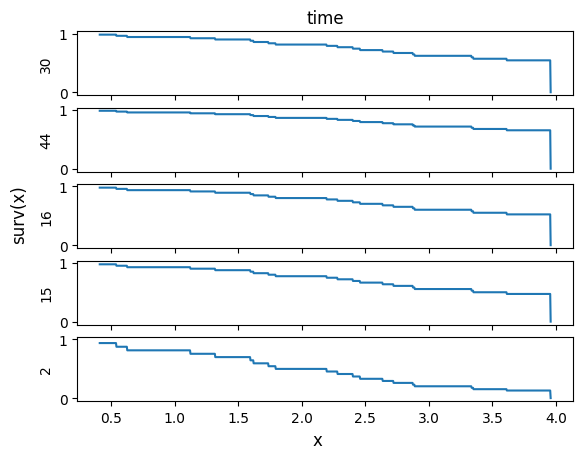

In [58]:
# plot of survival functions
y_pred_proba_cox.iloc[range(5)].plot("surv")

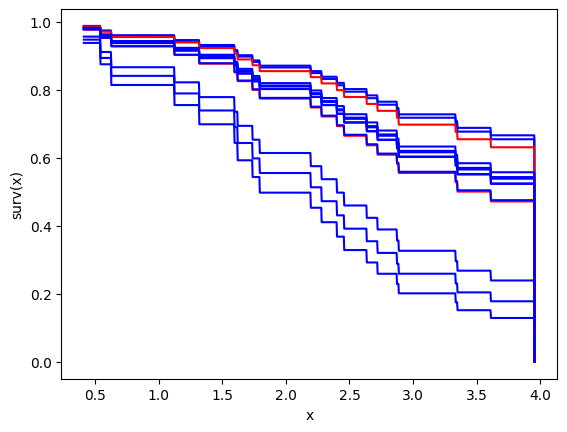

In [59]:
# plotting survival functions in one figure, smokers in red
from matplotlib.pyplot import subplots

_, ax = subplots()

for i in range(len(y_pred_proba_cox)):
    ax = y_pred_proba_cox.iat[i, 0].plot("surv", ax=ax, color=["b", "r"][smoker[i]])

### 1.3 survival prediction with parametric predictive distribution

example: using an accelerated failure time model with Weibull hazard

same workflow, only using different model:

In [60]:
from sklearn.model_selection import train_test_split

from skpro.survival.aft import AFTWeibull

# step 1: data specification
# X, y, C, as above
X_train, X_new, y_train, _, C_train, _ = train_test_split(X, y, C)

# step 2: specifying the regressor
# example - Cox proportional hazards model from statsmodels
surv_model_aft = AFTWeibull()

# step 3: fitting the model to training data
surv_model_aft.fit(X_train, y_train, C_train)

# step 4: predicting labels on new data

# full distribution prediction
y_pred_proba_aft = surv_model_aft.predict_proba(X_new)

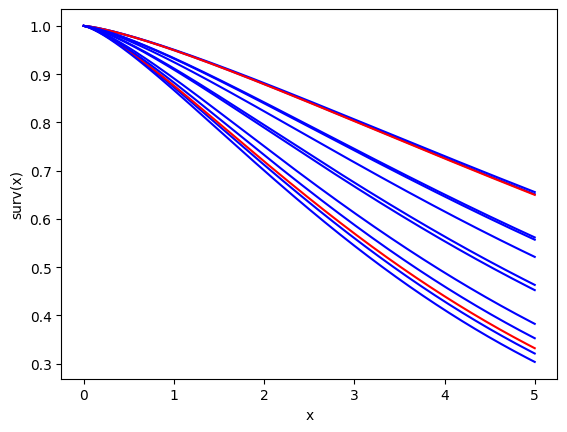

In [61]:
# plotting survival functions in one figure, smokers in red
from matplotlib.pyplot import subplots

_, ax = subplots()

for i in range(len(y_pred_proba_cox)):
    ax = y_pred_proba_aft.iat[i, 0].plot(
        "surv", ax=ax, color=["b", "r"][smoker[i]], x_bounds=[0, 5]
    )

hazard functions can be plotted the same way:

(<Figure size 640x480 with 5 Axes>,
 array([<Axes: title={'center': 'time'}, ylabel='22'>, <Axes: ylabel='1'>,
        <Axes: ylabel='42'>, <Axes: ylabel='19'>, <Axes: ylabel='32'>],
       dtype=object))

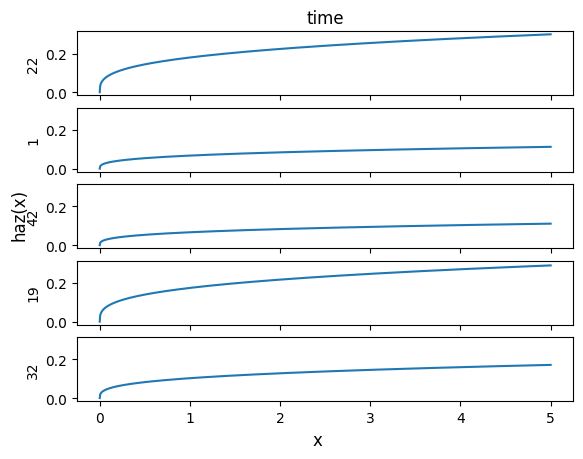

In [62]:
# plot of hazard functions
y_pred_proba_aft.iloc[range(5)].plot("haz", x_bounds=[0, 5])

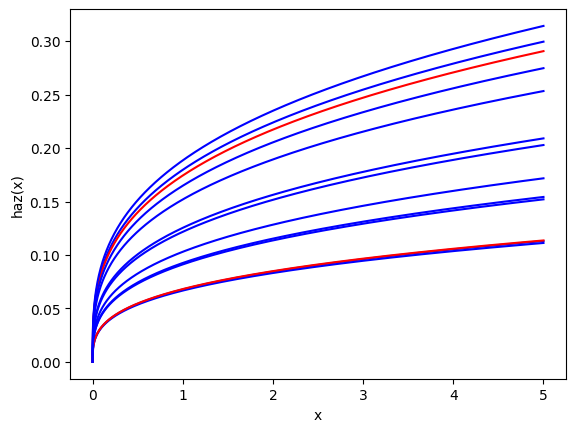

In [63]:
# plotting survival functions in one figure, smokers in red
from matplotlib.pyplot import subplots

_, ax = subplots()

for i in range(len(y_pred_proba_aft)):
    ax = y_pred_proba_aft.iat[i, 0].plot(
        "haz", ax=ax, color=["b", "r"][smoker[i]], x_bounds=[0, 5]
    )

In [64]:
# estimated scale parameter
y_pred_proba_aft.to_df().head()

time          
           k     scale
22  1.317596  4.537601
1   1.317596  9.504837
42  1.317596  9.621927
19  1.317596  4.642179
32  1.317596  6.921167

In [65]:
# actual Weibull scale parameter to compare
# unknown in a real scenario, but we know since we simulated the data
scale[0:5]

array([ 6.20222709, 10.67113911,  4.05813303,  4.30737777,  4.76504376])

### 1.4 finding time-to-event prediction models

Time-to-event (aka survival) prediction models are probabilistic regressors.

I.e., the type is `regressor_proba`, as for probabilistic regressors.

All probabilistic regressors can be used with for survival prediction as above.

But, only models with the `"capability:survival"` tag set to `True` use the censoring information in `C`.

Other models ignore `C`, which will lead to biased predictions (see section 3 on addressing this).

The `all_objects` utility can be used to retrieve time-to-event prediction models:

In [66]:
from skpro.registry import all_objects

# time-to-event predictors have "regressor_proba" type, i.e., probabilistic regressors
# the tag "capability:survival" = True indicates models that make use of C
all_objects(
    "regressor_proba", as_dataframe=True, filter_tags={"capability:survival": True}
).head()

,name,object
0,AFTFisk,<class 'skpro.survival.aft._aft_lifelines_fisk...
1,AFTLogNormal,<class 'skpro.survival.aft._aft_lifelines_logn...
2,AFTWeibull,<class 'skpro.survival.aft._aft_lifelines_weib...
3,AalenAdditive,<class 'skpro.survival.additive._aalen_lifelin...
4,BaggingRegressor,<class 'skpro.regression.ensemble._bagging.Bag...


### 1.5 simple evaluation workflow for time-to-event predictions

for simple evaluation:

1. split the data into train/test set - including the censoring variable
2. make predictions of either type for test features
3. compute metric on test set, comparing test predictions to held out test observations,
  including censoring indicsator

Note:

* metrics will compare probabilistic prediction to tabular ground truth and
  censoring indicator
* the metric needs to be of a compatible type, e.g., for distribution predictions
* special survival metrics are available to take into account censoring;
  if a non-survival metric is used, the censoring indicator will be ignored

In [67]:
from sklearn.model_selection import train_test_split

from skpro.metrics import ConcordanceHarrell
from skpro.survival.coxph import CoxPH

# step 1: data specification
X_train, X_test, y_train, y_test, C_train, C_test = train_test_split(X, y, C)

# step 2: specifying the regressor
# example - Cox proportional hazards model from statsmodels
surv_model = CoxPH()

# step 3: fitting the model to training data
surv_model.fit(X_train, y_train, C_train)

# step 4: predicting labels on new data
y_pred_proba = surv_model.predict_proba(X_test)

# step 5: specifying evaluation metric
metric = ConcordanceHarrell()

# step 6: evaluate metric, compare predictions to actuals
metric(y_test, y_pred_proba, C_true=C_test)

0.6491228070175438

how do we know that metric is a genuine survival metric?

Via the `capability:survival` tag:

In [68]:
metric.get_tags()
# capability:survival is True

{'estimator_type': 'estimator',
 'authors': 'fkiraly',
 'maintainers': 'skpro developers',
 'object_type': ['metric', 'metric_distr'],
 'reserved_params': ['multioutput', 'score_average'],
 'scitype:y_pred': 'pred_proba',
 'lower_is_better': False,
 'capability:survival': True}

how do we find specialized survival metrics?

In [69]:
from skpro.registry import all_objects

all_objects("metric", as_dataframe=True, filter_tags={"capability:survival": True})

,name,object
0,ConcordanceHarrell,<class 'skpro.metrics.survival._c_harrell.Conc...
1,SPLL,<class 'skpro.metrics.survival._spll.SPLL'>


All metrics can be applied to censored data:

metrics with the tag being `False` will ignore the censoring variable.

This will lead to bias in general, but can be justified if there is a low amount of censoring.

## 2. Benchmarking time-to-event models <a class="anchor" id="chapter2"></a>

The `benchmarking.evaluate` utility can be used for time-to-event models as well:

In [70]:
from sklearn.model_selection import KFold

from skpro.benchmarking.evaluate import evaluate
from skpro.metrics import ConcordanceHarrell
from skpro.survival.coxph import CoxPH

# 1. specify dataset
# X, y, C are as above

# 2. specify estimator
estimator = CoxPH()

# 3. specify cross-validation schema
cv = KFold(n_splits=3)

# 4. specify evaluation metric
c_index = ConcordanceHarrell()

# 5. evaluate - run the benchmark
# C needs to be passed here
# this will automatically pass it on the test set to the metric
results = evaluate(estimator=estimator, X=X, y=y, C=C, cv=cv, scoring=c_index)

# results are pd.DataFrame
# each row is one repetition of the cross-validation on one fold fit/predict/evaluate
# columns report performance, runtime, and other optional information (see docstring)
results

,test_ConcordanceHarrell,fit_time,pred_proba_time,len_y_train
0,0.620370,0.015508,0.019106,33
1,0.608696,0.007775,0.009308,33
2,0.608696,0.007695,0.008064,34


## 3. Advanced composition patterns <a class="anchor" id="chapter3"></a>

we introduce a number of composition patterns available in `skpro`:

* reducer-wrappers that turn `sklearn` regressors into survival regressors
* pipelines of `sklearn` transformers with `skpro` survival regressors
* tuning `skpro` survival regressors via grid/random search, minimizing a probabilistic metric

data used in this section:

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, C_train, C_test = train_test_split(X, y, C)

evaluation metric used in this section:

In [72]:
from skpro.metrics import ConcordanceHarrell

c_harrell = ConcordanceHarrell()

### 3.1 Reducers to create survival regressors <a class="anchor" id="section3_1"></a>

the three main reduction strategies to create survival regressors:

1. adding the capability to handle censoring information to a probabilistic supervised regressor
2. the above, combined with any strategy to create a probabilistic regressor from an `sklearn` (non-probabilistic) regressors
3. strategies that directly create a survival regressor from a tabular `sklearn` regressor

This section shows examples for all the above.

### 3.1.1 adding survival capability to a probabilistic regressor <a class="anchor" id="section3_1_1"></a>

this type of reduction strategy takes a probabilistic regressor and adds treatment for censored data.

Examples:

* native use - every probabilistic regressor can be used as a survival regressor, ignoring `C`
* `FitUncensored` - fits the model on the uncensored data only
* `ConditionUncensored` - uses `C` as a feature in fitting, and sets it to `C=0` in `Predict`

The first two strategies introduce bias into the model, and should only be applied when the censoring fraction is low.

Example with `ConditionUncensored`:

In [73]:
from skpro.regression.linear import GLMRegressor
from skpro.survival.compose import ConditionUncensored

# estimator specification - use any skpro regressor, including composites
reg_proba = GLMRegressor()

# turning the regressor into a survival predictor
surv_model = ConditionUncensored(reg_proba)

# fit and predict
surv_model.fit(X_train, y_train, C_train)
y_pred_proba = surv_model.predict_proba(X_test)

# evaluate
c_harrell(y_test, y_pred_proba, C_true=C_test)

0.3492063492063492

### 3.1.2 adding probabilistic then survival capability to `sklearn` regressor <a class="anchor" id="section3_1_2"></a>

In [74]:
from sklearn.ensemble import RandomForestRegressor

from skpro.regression.residual import ResidualDouble
from skpro.survival.compose import ConditionUncensored

# estimator specification - use any skpro regressor, including composites
reg_mean = RandomForestRegressor()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# turning the regressor into a survival predictor
surv_model = ConditionUncensored(reg_proba)

# fit and predict
surv_model.fit(X_train, y_train, C_train)
y_pred_proba = surv_model.predict_proba(X_test)

# evaluate
c_harrell(y_test, y_pred_proba, C_true=C_test)

0.5158730158730159

### 3.1.3 bootstrap prediction intervals <a class="anchor" id="section3_1_3"></a>

In [75]:
from sklearn.linear_model import LinearRegression

from skpro.regression.bootstrap import BootstrapRegressor

# estimator specification - use any sklearn regressor for reg_mean
reg_mean = LinearRegression()
reg_proba = BootstrapRegressor(reg_mean, n_bootstrap_samples=100)

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
c_harrell(y_test, y_pred_proba)

0.5384615384615384

### 3.2 Pipelines of `skpro` survival regressors and `sklearn` transformers <a class="anchor" id="section3_2"></a>

`skpro` survival regressors can be pipelined with `sklearn` transformers, using the `skpro` pipeline.

This ensure presence of `predict_proba` etc in the pipeline object.

The syntax is exactly the same as for `sklearn`'s pipeline,
or the `skpro` pipeline with non-survival regressors

In [76]:
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import MinMaxScaler

from skpro.regression.compose import Pipeline
from skpro.survival.coxph import CoxPH

# estimator specification
surv_model = CoxPH()

# pipeline is specified as a list of tuples (name, estimator)
pipe = Pipeline(
    steps=[
        ("imputer", Imputer()),  # an sklearn transformer
        ("scaler", MinMaxScaler()),  # an sklearn transformer
        ("regressor", surv_model),  # an skpro regressor
    ]
)

In [77]:
pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('regressor', CoxPH())])

In [78]:
# the pipeline behaves as any skpro regressor
pipe.fit(X_train, y_train, C_train)
y_pred = pipe.predict(X=X_test)
y_pred_proba = pipe.predict_proba(X=X_test)

the pipeline provides the familiar nested `get_params`, `set_params` interface:

nested parameters are keyed `componentname__parametername`

In [79]:
pipe.get_params()

{'steps': [('imputer', SimpleImputer()),
  ('scaler', MinMaxScaler()),
  ('regressor', CoxPH())],
 'imputer': SimpleImputer(),
 'scaler': MinMaxScaler(),
 'regressor': CoxPH(),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__keep_empty_features': False,
 'imputer__missing_values': nan,
 'imputer__strategy': 'mean',
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'regressor__alpha': 0.0,
 'regressor__method': 'lpl',
 'regressor__missing': 'drop',
 'regressor__strata': None,
 'regressor__ties': 'breslow'}

pipelines can also be created via simple lists of estimators,

in this case names are generated automatically:

In [80]:
# pipeline is specified as a list of tuples (name, estimator)
pipe = Pipeline(
    steps=[
        Imputer(),  # an sklearn transformer
        MinMaxScaler(),  # an sklearn transformer
        surv_model,  # an skpro regressor
    ]
)

### 3.3 Tuning of `skpro` regressors via grid and random search <a class="anchor" id="section3_3"></a>

`skpro` provides grid and random search tuners to tune arbitrary probabilistic regressors,

using probabilistic metrics.

Survival metrics can be used to tune survival regressors, same as non-survival regressors.

In [81]:
from sklearn.model_selection import KFold

from skpro.metrics import ConcordanceHarrell
from skpro.model_selection import GridSearchCV
from skpro.survival.coxph import CoxPH

# cross-validation specification for tuner
cv = KFold(n_splits=3)

# estimator to be tuned
estimator = CoxPH()

# tuning grid - partial likelihood or elastic net penalty?
param_grid = {"method": ["lpl", "elastic_net"]}

# metric to be optimized
c_harrell = ConcordanceHarrell()

# specification of the grid search tuner
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    cv=cv,
    scoring=c_harrell,
)

In [82]:
gscv

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=CoxPH(), param_grid={'method': ['lpl', 'elastic_net']},
             scoring=ConcordanceHarrell())

the grid search tuner behaves like any `skpro` survival regressor:

In [83]:
gscv.fit(X_train, y_train, C_train)
y_pred = gscv.predict(X_test)
y_pred_proba = gscv.predict_proba(X_test)

random search is similar, except that instead of a grid a parameter sampler should be specified:

In [84]:
from skpro.model_selection import RandomizedSearchCV

# only difference to GridSearchCV is the param_distributions argument

# specification of the random search parameter sampler
param_distributions = {"method": ["lpl", "elastic_net"]}

# specification of the random search tuner
rscv = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_distributions,
    cv=cv,
    scoring=c_harrell,
)

## 4. Extension guide - implementing your own time-to-event regressor <a class="anchor" id="chapter4"></a>


`skpro` is meant to be easily extensible, for direct contribution to `skpro` as well as for local/private extension with custom methods.

To get started:

* Follow the ["implementing estimator" developer guide](https://skpro.readthedocs.io/en/stable/developer_guide/add_estimators.html)
* Use the [survival regressor template](https://github.com/sktime/skpro/blob/main/extension_templates/survival.py) to get started

1. Read through the [survival regression extension template](https://github.com/sktime/skpro/blob/main/extension_templates/survival.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. Copy the proba regressor extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `skpro` or affiliated repository (if contributed extension), inside `skpro.survival`; rename the file and update the file docstring appropriately.
3. Address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, and at least one of the probabilistic prediction methods, preferably `_predict_proba` (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
4. To test your estimator manually: import your estimator and run it in the workflows in Section 1; then use it in the compositors in Section 3.
5. To test your estimator automatically: call `skpro.utils.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `skpro` or one of its affiliated packages, additionally:

* Add yourself as an author and/or a maintainer for the new estimator file(s), via `"authors"` and `"maintainers"` tag.
* Create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* In the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* Before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

## 5. Summary<a class="anchor" id="chapter5"></a>

* `skpro` is a unified interface toolbox for probabilistic supervised regression, that is, for prediction intervals, quantiles, fully distributional predictions, in a tabular regression setting. The interface is fully interoperable with `scikit-learn` and `scikit-base` interface specifications.

* `skpro` comes with rich composition functionality that allows to build complex pipelines easily, and connect easily with other parts of the open source ecosystem, such as `scikit-learn` and individual algorithm libraries.

* `skpro` is easy to extend, and comes with user friendly tools to facilitate implementing and testing your own probabilistic regressors and composition principles.

---

### Credits:

noteook creation: fkiraly

skpro: https://github.com/sktime/skpro/blob/main/CONTRIBUTORS.md